In [38]:
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import healpy as hp
import rubin_sim.maf as maf
import rubin_sim.photUtils as photUtils
import rubin_sim.site_models as site_models
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_data_dir, get_baseline
import syseng_throughputs as st

## m5 and Cm Evaluation ##

Rubin Observatory has minimum and design requirements on single-visit point source magnitude limits (`m5`, limiting magnitudes, m5 depth, etc.). These are encoded in the LSST Science Requirements Document (SRD), but were formulated under initial assumptions of observing conditions and potential throughputs. As we progress towards operations, we have more information on the as-built system (throughputs, readnoise, etc) and have been gathering more information on site conditions (seeing and skybrightness). Our model of the expected single-visit limiting magnitudes can thus be improved. 

One complicating factor in looking at the resulting expected m5 depths is to separate the effects of the hardware being built from the effects of improving our understanding of the observing conditions. To aid with this, we include evaluations of `Cm`, which encodes the throughput of the system at a fixed set of skybrightness, seeing, exposure time, and airmass. 

The expected depths can also vary depending on survey strategy. To separate the observatory from the survey cadence, we also evaluate the expected depths in a limited set of conditions; where the airmass is minimum (at zenith, `X=1`), in dark-sky (new moon) conditions, and at the median predicted seeing. This matches the observing conditions defined in the SRD.

In [39]:
# To compare against SRD and Overview paper values, we will use the Cm value, potentially as well as m5
# The benefit of Cm is that it translates whatever is being achieved in m5 against a fixed set of fiducial
# assumptions -- assuming that the seeing is 0.7 and the skybrightness is 21. 
def m5_to_Cm(m5, skyMag, fwhmEff, kAtm, expTimeTotal=30, X=1.0):
    Cm = (m5 
          - 0.5 * (skyMag - 21) 
          - 2.5 * np.log10(0.7/fwhmEff) 
          - 1.25 * np.log10(expTimeTotal/30.0) 
          + kAtm * (X-1))
    return Cm

SRD only

In [40]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')

# Fiducial M5 values from the SRD
m5_fid = {'u': 23.9, 'g': 25.0, 'r': 24.7, 'i': 24.0, 'z': 23.3, 'y': 22.1}
m5_min = {'u': 23.4, 'g': 24.6, 'r': 24.3, 'i': 23.6, 'z': 22.9, 'y': 21.7}

In [41]:
pd.set_option('precision', 3)
pd.DataFrame([m5_fid, m5_min], index=['SRD m5 design', 'SRD m5 minimum'])

,u,g,r,i,z,y
SRD m5 design,23.9,25.0,24.7,24.0,23.3,22.1
SRD m5 minimum,23.4,24.6,24.3,23.6,22.9,21.7


In [42]:
# Calculate Cm values corresponding to these SRD m5 values
# For the SRD values, these will be calculated using the seeing and sky values from 
# the initial version of table 2 from the LSE-40 
# http://faculty.washington.edu/ivezic/Teaching/Astr511/LSST_SNRdoc.pdf
# (using y4 for y band)

kAtm_srd = {'u': 0.451,
           'g': 0.163,
           'r': 0.087,
           'i': 0.065,
           'z': 0.043,
           'y': 0.138}

seeing_srd = {'u': 0.77,
             'g': 0.73,
             'r': 0.70,
             'i': 0.67,
             'z': 0.65,
             'y': 0.63}

skymag_srd = {'u': 22.92,
             'g': 22.27,
             'r': 21.20,
             'i': 20.47,
             'z': 19.59,
             'y': 18.63}
for f in skymag_srd:
    skymag_srd[f] = skymag_srd[f] - 0.2

m5 = {}
m5['srd min'] = m5_min
m5['srd'] = m5_fid

Cm = {}
Cm['srd min'] = {}
Cm['srd'] = {}

for f in filterlist:
    Cm['srd min'][f] = m5_to_Cm(m5['srd min'][f], skymag_srd[f], seeing_srd[f], kAtm_srd[f], X=1.0)
    Cm['srd'][f] = m5_to_Cm(m5['srd'][f], skymag_srd[f], seeing_srd[f], kAtm_srd[f], X=1.0)
keys = ['srd min', 'srd']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys] + [kAtm_srd, seeing_srd, skymag_srd],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys] + ['kAtm srd', 'seeing srd', 'sky srd'])

,u,g,r,i,z,y
m5 srd min,23.400,24.600,24.300,23.600,22.900,21.700
m5 srd,23.900,25.000,24.700,24.000,23.300,22.100
Cm srd min,22.643,24.111,24.300,23.917,23.625,22.871
Cm srd,23.143,24.511,24.700,24.317,24.025,23.271
kAtm srd,0.451,0.163,0.087,0.065,0.043,0.138
seeing srd,0.770,0.730,0.700,0.670,0.650,0.630
sky srd,22.720,22.070,21.000,20.270,19.390,18.430


Ok, let's load up the current design and as-built information on the actual system components. 

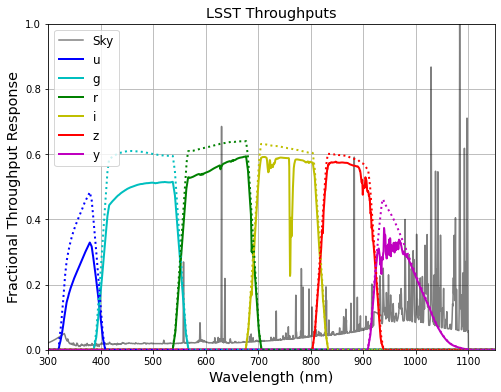

In [43]:
# Set up to read components (from syseng_throughputs repository)
throughputDirs = st.setDefaultDirs()

# Read dark sky and X=1 atmosphere (default is to use X=1.2 atmosphere otherwise)
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(st.findRootDir(), 'siteProperties', 'darksky.dat'))
atmosphere = st.readAtmosphere(throughputDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

# Read components, directly from syseng_throughputs repository
throughputDirs = st.setDefaultDirs()
# READ WITHOUT ANY SYSTEM LOSSES
hardware, system = st.buildHardwareAndSystem(throughputDirs, atmosphereOverride=atmosphere, addLosses=False)


plt.figure(figsize=(8,6))
plt.plot(darksky.wavelen, darksky.flambda/darksky.flambda.max(), 'k-', alpha=0.5, label='Sky')
st.plotBandpasses(system, 'LSST Throughputs', newfig=False, addlegend=True)
plt.legend(loc='upper left', fancybox=True, fontsize='large')
st.plotBandpasses(hardware, newfig=False, linestyle=':', addlegend=False)

In [44]:
# Pull in design values, related to current SRD-style calculations

# Set up PhotometricParameters object - which stores readnoise, etc
readnoise = 8.8 # e-/read
darkcurrent = 0.2 # e-/s
photParameters_15 = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1, 
                                                     readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
photParameters_30 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1,
                                                   readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
# Make it easier to retrieve the appropriate version per-bandpass
photParams = {}
photParams['u'] = photParameters_30
for f in ('g', 'r', 'i', 'z', 'y'):
    photParams[f] = photParameters_15

# Fiducial seeing values 
# These fiducial seeing values correspond to a 500nm zenith atmospheric seeing contribution 
# equivalent to fwhm_500 = 0.62" (using our current seeing model) - see next cell
lsstDefaults = photUtils.LSSTdefaults()
fid_fwhmEff = {}
for f in filterlist:
    fid_fwhmEff[f] = lsstDefaults.FWHMeff(f)

In [45]:
# Let's look at the progression of fwhm_500 and expected seeing per bandpass at X=1 from SRD to simulation
srd_fwhm_500 = 0.475
fid_fwhm_500 = 0.62
db_med_fwhm_500 = 0.72 # this is from the median FWHM_500 from a survey simulation .. see cell far below
seeing_model = site_models.SeeingModel()
d = pd.DataFrame([list(seeing_srd.values()), seeing_model(srd_fwhm_500, 1)['fwhmEff'],
             [fid_fwhmEff[f] for f in filterlist], seeing_model(fid_fwhm_500, 1)['fwhmEff'],
             seeing_model(db_med_fwhm_500, 1)['fwhmEff']], 
             index=['SRD seeing', 'SRD modeled seeing (0.475")', 
                      'fiducial seeing', 'fiducial -> modeled seeing (0.62")',
                   'sim fwhm500 -> modeled seeing (0.72")'],
             columns=filterlist)
d

,u,g,r,i,z,y
SRD seeing,0.770,0.730,0.700,0.670,0.650,0.630
"SRD modeled seeing (0.475"")",0.771,0.733,0.700,0.679,0.664,0.652
fiducial seeing,0.920,0.870,0.830,0.800,0.780,0.760
"fiducial -> modeled seeing (0.62"")",0.928,0.875,0.828,0.796,0.775,0.758
"sim fwhm500 -> modeled seeing (0.72"")",1.043,0.978,0.922,0.884,0.857,0.837


In [46]:
# This progression in seeing *alone* would result in a change in limiting magnitude of about:
def dmag(fwhmEff):
    return 2.5 * np.log10(0.7/fwhmEff)
dd = dmag(d)
dd.index = [f'dmag {v}'  for v in d.index]
dd = dd - dd.loc['dmag SRD seeing']
dd

,u,g,r,i,z,y
dmag SRD seeing,0.000e+00,0.000,0.000e+00,0.000,0.000,0.000
"dmag SRD modeled seeing (0.475"")",-9.512e-04,-0.005,-5.405e-04,-0.014,-0.023,-0.038
dmag fiducial seeing,-1.932e-01,-0.190,-1.850e-01,-0.193,-0.198,-0.204
"dmag fiducial -> modeled seeing (0.62"")",-2.028e-01,-0.196,-1.820e-01,-0.188,-0.190,-0.201
"dmag sim fwhm500 -> modeled seeing (0.72"")",-3.292e-01,-0.318,-2.987e-01,-0.300,-0.300,-0.308


In [47]:
# How much did the limiting magnitude (X=1) change due to the change in expected FWHM_500 from the fiducial to new db?
dd - dd.loc['dmag fiducial -> modeled seeing (0.62")']

,u,g,r,i,z,y
dmag SRD seeing,0.203,0.196,0.182,0.188,0.190,0.201
"dmag SRD modeled seeing (0.475"")",0.202,0.192,0.181,0.174,0.168,0.163
dmag fiducial seeing,0.010,0.006,-0.003,-0.005,-0.008,-0.003
"dmag fiducial -> modeled seeing (0.62"")",0.000,0.000,0.000,0.000,0.000,0.000
"dmag sim fwhm500 -> modeled seeing (0.72"")",-0.126,-0.122,-0.117,-0.113,-0.110,-0.107


In [48]:
# Calculate extinction coefficients to translate to Cm - 
# these will be the same for every use of the throughput curves
Tb = {}
Sb = {}
kAtm = {}
skyMag = {}
for f in filterlist:
    dwavelen = np.unique(np.diff(system[f].wavelen)).mean()
    Tb[f] = np.sum(system[f].sb / system[f].wavelen) * dwavelen
    Sb[f] = np.sum(hardware[f].sb / hardware[f].wavelen) * dwavelen
    kAtm[f] = -2.5 * np.log10(Tb[f] / Sb[f])
    # Can calculate skyMag here too as it is atmosphere and seeing independent 
    skyMag[f] = darksky.calcMag(hardware[f])
pd.DataFrame([kAtm_srd, kAtm, skymag_srd, skyMag, seeing_srd, fid_fwhmEff], 
             index=['kAtm SRD', 'kAtm system', 
                    'skyMag SRD', 'skyMag fiducial', 
                    'seeing SRD', 'seeing fiducial'])

,u,g,r,i,z,y
kAtm SRD,0.451,0.163,0.087,0.065,0.043,0.138
kAtm system,0.501,0.215,0.126,0.096,0.069,0.170
skyMag SRD,22.720,22.070,21.000,20.270,19.390,18.430
skyMag fiducial,22.963,22.261,21.196,20.477,19.600,18.611
seeing SRD,0.770,0.730,0.700,0.670,0.650,0.630
seeing fiducial,0.920,0.870,0.830,0.800,0.780,0.760


In [53]:
# Calculate m5 and Cm values that result from using *these* throughputs with SRD values for sky and seeing
# (corresponds to 0.475" 500nm zenith seeing)

k = 'srd system'
m5[k] = {}
Cm[k] = {}

for f in filterlist:
    # Assume the dark sky sed is good to use for the shape of the sky, but rescale to have the expected
    # dark_sky value magnitude
    darksky_copy = photUtils.Sed()
    darksky_copy.setSED(wavelen = darksky.wavelen, flambda = darksky.flambda)
    fluxNorm = darksky_copy.calcFluxNorm(skymag_srd[f], hardware[f])
    darksky_copy.multiplyFluxNorm(fluxNorm)    
    m5[k][f] = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                photParameters_15, FWHMeff=seeing_srd[f])
    
    Cm[k][f] = m5_to_Cm(m5[k][f], skymag_srd[f], seeing_srd[f], kAtm[f], X=1.0)

    
keys = ['srd', 'srd system']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900,25.000,24.70,24.000,23.300,22.100
m5 srd system,24.226,25.081,24.58,24.153,23.580,22.700
Cm srd,23.143,24.511,24.70,24.317,24.025,23.271
Cm srd system,23.470,24.592,24.58,24.471,24.304,23.870


In [50]:
# A side-trip to look at the total effective survey time, for the minimum/design/SRD-referenced system
srd_time_distribution = {'u': 0.068, 'g': 0.097, 'r': 0.223, 'i': 0.223, 'z': 0.194, 'y': 0.194}
def calculate_effective_time(m5vals):
    weighted_time = {}
    for f in m5vals:
        dtime = np.power(10, -0.8 * (m5vals[f] - m5['srd'][f]))
        weighted_time[f] = dtime * srd_time_distribution[f]
    weighted_time['total'] = np.array(list(weighted_time.values())).sum()
    return weighted_time

teff_srd_min = calculate_effective_time(m5['srd min']) 
teff_srd_design = calculate_effective_time(m5['srd'])
teff_srd_system = calculate_effective_time(m5['srd system'])
pd.DataFrame([m5['srd min'], teff_srd_min, m5['srd'], teff_srd_design, m5['srd system'], teff_srd_system], 
             index=['m5 srd min', 'teff srd min', 'm5 srd', 'teff srd', 'm5 srd system', 'teff srd system'])


,u,g,r,i,z,y,total
m5 srd min,23.400,24.600,24.300,23.600,22.900,21.700,NaN
teff srd min,0.171,0.203,0.466,0.466,0.405,0.405,2.116
m5 srd,23.900,25.000,24.700,24.000,23.300,22.100,NaN
teff srd,0.068,0.097,0.223,0.223,0.194,0.194,0.999
m5 srd system,24.226,25.081,24.580,24.153,23.580,22.700,NaN
teff srd system,0.037,0.084,0.278,0.168,0.116,0.064,0.747


In [54]:
# TABLE 1
d = pd.DataFrame([m5[k] for k in ['srd', 'srd min', 'srd system']] + 
                 [seeing_srd, skymag_srd, Cm['srd system']],
                index=['SRD design', 'SRD minimum', 'm5 predicted', 'seeing', 'skybrightness', 'Cm predicted'])
pd.set_option('precision', 2)
print(d.to_latex())
pd.set_option('precision', 3)
d

\begin{tabular}{lrrrrrr}
\toprule
{} &      u &      g &      r &      i &      z &      y \\
\midrule
SRD design    &  23.90 &  25.00 &  24.70 &  24.00 &  23.30 &  22.10 \\
SRD minimum   &  23.40 &  24.60 &  24.30 &  23.60 &  22.90 &  21.70 \\
m5 predicted  &  24.23 &  25.08 &  24.58 &  24.15 &  23.58 &  22.70 \\
seeing        &   0.77 &   0.73 &   0.70 &   0.67 &   0.65 &   0.63 \\
skybrightness &  22.72 &  22.07 &  21.00 &  20.27 &  19.39 &  18.43 \\
Cm predicted  &  23.47 &  24.59 &  24.58 &  24.47 &  24.30 &  23.87 \\
\bottomrule
\end{tabular}



,u,g,r,i,z,y
SRD design,23.900,25.000,24.70,24.000,23.300,22.10
SRD minimum,23.400,24.600,24.30,23.600,22.900,21.70
m5 predicted,24.226,25.081,24.58,24.153,23.580,22.70
seeing,0.770,0.730,0.70,0.670,0.650,0.63
skybrightness,22.720,22.070,21.00,20.270,19.390,18.43
Cm predicted,23.470,24.592,24.58,24.471,24.304,23.87


In [16]:
# Calculate dark sky, X=1.0, srd_fiducial seeing m5 and Cm values 
# "throughputs" == throughput components, X=1.0, dark sky sed, 
#  and fiducial seeing (corresponds to 0.62" 500nm zenith seeing)

k = 'fiducial system'
m5[k] = {}
Cm[k] = {}

for f in filterlist:
    m5[k][f] = photUtils.calcM5(darksky, system[f], hardware[f],
                                photParams[f], FWHMeff=fid_fwhmEff[f])
    
    Cm[k][f] = m5_to_Cm(m5[k][f], skyMag[f], fid_fwhmEff[f], kAtm[f], X=1.0)

    
keys = ['srd', 'srd system', 'fiducial system']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900,25.000,24.700,24.000,23.300,22.100
m5 srd system,24.391,25.081,24.580,24.153,23.580,22.700
m5 fiducial system,24.271,24.967,24.482,24.056,23.481,22.583
Cm srd,23.143,24.511,24.700,24.317,24.025,23.271
Cm srd system,23.634,24.592,24.580,24.471,24.304,23.870
Cm fiducial system,23.586,24.572,24.569,24.462,24.299,23.867


In [17]:
d2 = pd.DataFrame([m5[k] for k in ['srd', 'srd min', 'fiducial system']] + 
                 [fid_fwhmEff, skyMag, Cm['fiducial system']],
                index=['SRD design', 'SRD minimum', 'm5 predicted', 'seeing', 'skybrightness', 'Cm predicted'])
print(d)
print(d2)
print()
pd.set_option('precision', 2)
print(d2.to_latex())
pd.set_option('precision', 3)

                    u       g      r       i       z      y
SRD design     23.900  25.000  24.70  24.000  23.300  22.10
SRD minimum    23.400  24.600  24.30  23.600  22.900  21.70
m5 predicted   24.391  25.081  24.58  24.153  23.580  22.70
seeing          0.770   0.730   0.70   0.670   0.650   0.63
skybrightness  22.720  22.070  21.00  20.270  19.390  18.43
Cm predicted   23.634  24.592  24.58  24.471  24.304  23.87
                    u       g       r       i       z       y
SRD design     23.900  25.000  24.700  24.000  23.300  22.100
SRD minimum    23.400  24.600  24.300  23.600  22.900  21.700
m5 predicted   24.271  24.967  24.482  24.056  23.481  22.583
seeing          0.920   0.870   0.830   0.800   0.780   0.760
skybrightness  22.963  22.261  21.196  20.477  19.600  18.611
Cm predicted   23.586  24.572  24.569  24.462  24.299  23.867

\begin{tabular}{lrrrrrr}
\toprule
{} &      u &      g &      r &      i &      z &      y \\
\midrule
SRD design    &  23.90 &  25.00 &  24.70 &

### Going beyond the fiducial values, to more current expected values ### 

And add an update to the sky brightness model, coming from rubin_sim.skybrightness. The primary difference here is that the new model is capable of generating sky brightness over a range of conditions, instead of a single dark-sky SED as above. The dark sky skybrightness values between the two are similar, although not exactly the same. The new model is validated against photometry measurements both from the site and nearby; the single SED is a composite documented in LSE-40 (referenced above). 

The new sky model is somewhat brighter in 'u' band, however, 'u' is still read-noise limited so this isn't a significant impact. 

We'll add this first, instead of the longer time baseline seeing, as it's a smaller impact. 

In [18]:
# Our skybrightness model, even at dark sky, advances beyond the dark sky sed
# Note that this difference is primarily due to the fact that the skybrightness model is fitting observed
# sky values from the site and near the site -- instead of fitting an expected SED to older skybrightness
# values from a different site
# These are still zenith (X~1) values
# values pulled from https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/science/teff_fiducial.ipynb
dark_sky = {'u': 22.68,
           'g': 22.11,
           'r': 21.11,
           'i': 20.39,
           'z': 19.43,
           'y': 18.63}

pd.DataFrame([skymag_srd, skyMag, dark_sky], index=['SRD sky mag', 'SED sky mag', 'Model sky mag'])

,u,g,r,i,z,y
SRD sky mag,22.720,22.070,21.000,20.270,19.39,18.430
SED sky mag,22.963,22.261,21.196,20.477,19.60,18.611
Model sky mag,22.680,22.110,21.110,20.390,19.43,18.630


In [19]:
# Add the dark sky model instead of the dark sky SED calculated dark sky

k = 'model sky'
m5[k] = {}
Cm[k] = {}


for f in filterlist:
    # Assume the dark sky sed is good to use for the shape of the sky, but rescale to have the expected
    # dark_sky value magnitude
    darksky_copy = photUtils.Sed()
    darksky_copy.setSED(wavelen = darksky.wavelen, flambda = darksky.flambda)
    fluxNorm = darksky_copy.calcFluxNorm(dark_sky[f], hardware[f])
    darksky_copy.multiplyFluxNorm(fluxNorm)
    m5[k][f] = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                             photParams[f], FWHMeff=fid_fwhmEff[f])
    Cm[k][f] = m5_to_Cm(m5[k][f], dark_sky[f], fid_fwhmEff[f], kAtm[f], X=1.0)

    
keys = ['srd', 'srd system', 'fiducial system', 'model sky']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900,25.000,24.700,24.000,23.300,22.100
m5 srd system,24.391,25.081,24.580,24.153,23.580,22.700
m5 fiducial system,24.271,24.967,24.482,24.056,23.481,22.583
m5 model sky,24.191,24.909,24.445,24.017,23.402,22.592
Cm srd,23.143,24.511,24.700,24.317,24.025,23.271
Cm srd system,23.634,24.592,24.580,24.471,24.304,23.870
Cm fiducial system,23.586,24.572,24.569,24.462,24.299,23.867
Cm model sky,23.648,24.590,24.575,24.467,24.305,23.866


(note: the Cm value for u band changes above when the new sky values are introduced; in general it should not, but it does here because u band is readnoise limited, not sky-noise limited. As a result, Cm can change because it includes underlying assumptions that the m5 limit is due to sky-noise only. In use, this is compensated for with an additional term, 'dCm'). 

Update the seeing beyond the fiducial values. 

For the simulations, have an updated seeing distribution, based on an updated 'raw seeing' (FWHM_500) distribution.
The new model is based on a longer time baseline of seeing values (this is the primary difference to the source of the 'fiducial' value above). 

In [20]:
# Our current best simulation of the seeing is documented in https://rtn-022.lsst.io
# The expected seeing is that the median fwhm_500 = 0.7" 
# note that below, we look at the actual distribution achieved in a simulation and find 0.72" (downtime, weather..)

seeing_db_file = os.path.join(get_data_dir(), 'site_models', "simsee_pachon_58777_16.db")
conn = sqlite3.connect(seeing_db_file)
seeing_data = pd.read_sql('select seeing from Seeing', conn)

Text(0.4, 0.5, 'Median FWHM 500nm 0.70')

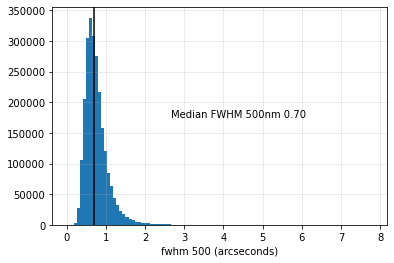

In [21]:
n,b,p = plt.hist(seeing_data['seeing'], bins=100)
plt.xlabel('fwhm 500 (arcseconds)')
plt.grid(alpha=0.3)
med_fwhm_500 = np.median(seeing_data['seeing'])
plt.axvline(med_fwhm_500, color='k')
plt.figtext(0.4, 0.5, s=f'Median FWHM 500nm {med_fwhm_500:.2f}')

In [22]:
# Calculate the corresponding X=1.0 delivered seeing per band
db_fwhmEff = dict(zip(filterlist, seeing_model(med_fwhm_500, 1.0)['fwhmEff']))
# and pull this up from below where we query simulation for actual median fwhm_500 
sim_fwhmEff = dict(zip(filterlist, seeing_model(0.72, 1.0)['fwhmEff']))

pd.DataFrame([seeing_srd, fid_fwhmEff, db_fwhmEff, sim_fwhmEff], 
             index=['SRD seeing', 'fiducial seeing', 'model raw database median seeing', 'model sim median seeing'])

,u,g,r,i,z,y
SRD seeing,0.770,0.730,0.700,0.670,0.650,0.630
fiducial seeing,0.920,0.870,0.830,0.800,0.780,0.760
model raw database median seeing,1.019,0.957,0.902,0.866,0.840,0.820
model sim median seeing,1.043,0.978,0.922,0.884,0.857,0.837


In [23]:
# Dark sky model + update in fwhm500 median value

k = 'model sky + model seeing'
m5[k] = {}
Cm[k] = {}


for f in filterlist:
    # Assume the dark sky sed is good to use for the shape of the sky, but rescale to have the expected
    # dark_sky value magnitude
    darksky_copy = photUtils.Sed()
    darksky_copy.setSED(wavelen = darksky.wavelen, flambda = darksky.flambda)
    fluxNorm = darksky_copy.calcFluxNorm(dark_sky[f], hardware[f])
    darksky_copy.multiplyFluxNorm(fluxNorm)
    m5[k][f] = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                             photParams[f], FWHMeff=db_fwhmEff[f])
    Cm[k][f] = m5_to_Cm(m5[k][f], dark_sky[f], db_fwhmEff[f], kAtm[f], X=1.0)

    
keys = ['srd', 'srd system', 'fiducial system', 'model sky', 'model sky + model seeing']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900,25.000,24.700,24.000,23.300,22.100
m5 srd system,24.391,25.081,24.580,24.153,23.580,22.700
m5 fiducial system,24.271,24.967,24.482,24.056,23.481,22.583
m5 model sky,24.191,24.909,24.445,24.017,23.402,22.592
m5 model sky + model seeing,24.082,24.807,24.355,23.932,23.322,22.510
Cm srd,23.143,24.511,24.700,24.317,24.025,23.271
Cm srd system,23.634,24.592,24.580,24.471,24.304,23.870
Cm fiducial system,23.586,24.572,24.569,24.462,24.299,23.867
Cm model sky,23.648,24.590,24.575,24.467,24.305,23.866
Cm model sky + model seeing,23.650,24.592,24.576,24.468,24.305,23.867


In [24]:
k = 'model dark sky + sim median seeing X=1.0'
m5[k] = {}
Cm[k] = {}


for i, f in enumerate(filterlist):
    # Assume the dark sky sed is good to use for the shape of the sky, but rescale to have the expected
    # dark_sky value magnitude
    darksky_copy = photUtils.Sed()
    darksky_copy.setSED(wavelen = darksky.wavelen, flambda = darksky.flambda)
    fluxNorm = darksky_copy.calcFluxNorm(dark_sky[f], hardware[f])
    darksky_copy.multiplyFluxNorm(fluxNorm)
    m5[k][f] = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                             photParams[f], FWHMeff=sim_fwhmEff[f])
    Cm[k][f] = m5_to_Cm(m5[k][f], dark_sky[f], sim_fwhmEff[f], kAtm[f], X=1.0)

    
keys = ['srd min', 'srd', 'srd system', 'fiducial system', 'model sky', 'model sky + model seeing', k]
d = pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])
d - d.loc['m5 srd system']

,u,g,r,i,z,y
m5 srd min,-0.991,-0.481,-0.280,-0.553,-0.680,-1.000
m5 srd,-0.491,-0.081,0.120,-0.153,-0.280,-0.600
m5 srd system,0.000,0.000,0.000,0.000,0.000,0.000
m5 fiducial system,-0.119,-0.115,-0.098,-0.097,-0.099,-0.117
m5 model sky,-0.200,-0.172,-0.135,-0.136,-0.178,-0.108
m5 model sky + model seeing,-0.308,-0.274,-0.225,-0.221,-0.257,-0.190
m5 model dark sky + sim median seeing X=1.0,-0.333,-0.298,-0.248,-0.243,-0.279,-0.211
Cm srd min,-1.747,-0.971,-0.280,-0.236,0.045,0.171
Cm srd,-1.247,-0.571,0.120,0.164,0.445,0.571
Cm srd system,-0.757,-0.489,0.000,0.317,0.725,1.171


## Add simulations of survey cadence ##

First, we note that the code used to calculate the m5 depths in the simulations is slightly different than the calculation above; for both speed and to be able to calculate m5 depths in all ranges of airmass, seeing, and sky brightness, we use the Cm equation reference above to calculate m5. Thus it's important to note the values of Cm being used to calculate m5 depths coming from the opsim outputs, and to verify that they match the Cm values that would be generated by our current throughputs.

In [25]:
# What values for Cm are used in the cadence simulations?
# These are calculated based on 30s visits and X=1.2 -- see below 
# (SysEngVals is the piece of code we store the refence numbers, but is calculated as in next cell)

vals = rsUtils.SysEngVals()
Cm_cadence_reference = vals.Cm

# The reference values can be recreated as follows:
Cm_cadence_calc = {}
for f in filterlist:
    m5_tmp = photUtils.calcM5(darksky, system[f], hardware[f],
                                photParameters_30, FWHMeff=fid_fwhmEff[f])
    
    Cm_cadence_calc[f] = m5_to_Cm(m5_tmp, skyMag[f], fid_fwhmEff[f], kAtm[f], X=1.0)

pd.DataFrame([Cm_cadence_reference, Cm_cadence_calc], 
             index=['Cm cadence reference', 'Cm cadence calculated'])

,u,g,r,i,z,y
Cm cadence reference,23.390,24.507,24.490,24.373,24.203,23.769
Cm cadence calculated,23.586,24.638,24.606,24.489,24.317,23.881


In [26]:
# The Cm cadence values above are used for simulations, but are scaled appropriately for the given exposure time 
# and conditions. The scaling can introduce errors up to but typically less than 0.01 magnitudes.
# We use rubin_sim.utils.m5_flat_sed for this scaling.

k = 'cadence reference'
m5[k] = {}
Cm[k] = Cm_cadence_reference

for f in filterlist:
    if f == 'u':
        expTime = 30
        nexp = 1
    else:
        expTime = 15
        nexp = 2
    m5[k][f] = rsUtils.m5_flat_sed(f, dark_sky[f], db_fwhmEff[f], expTime=expTime, airmass=1.0, nexp=nexp)
    
keys = ['srd', 'fiducial system', 'model sky', 'model sky + model seeing', 'cadence reference']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

,u,g,r,i,z,y
m5 srd,23.900,25.000,24.700,24.000,23.300,22.100
m5 fiducial system,24.271,24.967,24.482,24.056,23.481,22.583
m5 model sky,24.191,24.909,24.445,24.017,23.402,22.592
m5 model sky + model seeing,24.082,24.807,24.355,23.932,23.322,22.510
m5 cadence reference,23.887,24.659,24.229,23.808,23.203,22.393
Cm srd,23.143,24.511,24.700,24.317,24.025,23.271
Cm fiducial system,23.586,24.572,24.569,24.462,24.299,23.867
Cm model sky,23.648,24.590,24.575,24.467,24.305,23.866
Cm model sky + model seeing,23.650,24.592,24.576,24.468,24.305,23.867
Cm cadence reference,23.390,24.507,24.490,24.373,24.203,23.769


The Cm values in the simulation ('vals') are appropriate for use in the scaling function, and match what is expected from the system throughputs, as calculated above ('Cm cadence reference'). The m5 values above are calculated for the appropriate exposure time and number of exposures per visit, consistent with the 'model sky + model seeing'.

### Evaluating m5 depths in cadence outputs. ###

In practice, the LSST observations will cover a range of airmasses, skybrightness, and seeing values, which will all impact the five sigma point source magnitude limit (m5). The conditions above are for dark sky and zenith (X=1) conditions; all real-world observations will result in m5 values which are shallower, as airmass and sky brightness can only increase. The seeing above is a median, so sometimes we will acquire images with better seeing and thus potentially fainter m5 values. These ranges can be influenced by survey strategy, but only up to an given extent as we will use all available time (and thus have to accept a range of sky brightness and seeing). 

In addition, the final coadded depth is dependent on the number of visits acquired at any point in the sky, which is strongly dependent on survey strategy, although again has limitations around the total survey lifetime, minimum survey area, and observing duty-cycle requirements. 

In [27]:
# In an implemented survey, such as baseline_v2.0_10yrs -- 
# we have a range of airmasses, seeing, and skybrightness values

# Pull up median values of each of these

opsim_db_file = get_baseline()
runName = os.path.split(opsim_db_file)[-1].replace('.db', '')
outDir = 'm5_metrics'
resultsDb = maf.ResultsDb(outDir)
print(runName)

baseline_v2.0_10yrs


In [28]:
colmap = maf.ColMapDict()
colmap['skyBrightness'], colmap['seeingEff'], colmap['fiveSigmaDepth']

('skyBrightness', 'seeingFwhmEff', 'fiveSigmaDepth')

In [29]:
# Identify WFD footprint
nside = 64
footprint = maf.MetricBundle(maf.CountMetric('observationStartMJD', metricName='nvisits'), 
                            maf.HealpixSlicer(nside=nside), constraint=None, runName=runName)
g = maf.MetricBundleGroup({'footprint': footprint}, opsim_db_file, outDir=outDir, resultsDb=resultsDb)
g.runAll()
wfd_footprint = np.where(footprint.metricValues.filled(0) >= 750, footprint.metricValues.filled(0), 0)

allsky_slicer = maf.HealpixSlicer(nside=nside)
wfd_slicer = maf.HealpixSubsetSlicer(nside=nside, hpid=np.where(wfd_footprint>0)[0])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying table None with no constraint for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'rotSkyPos'].
Found 2086980 visits
Running:  ['footprint']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


area in wfd footprint 18620.568812654947


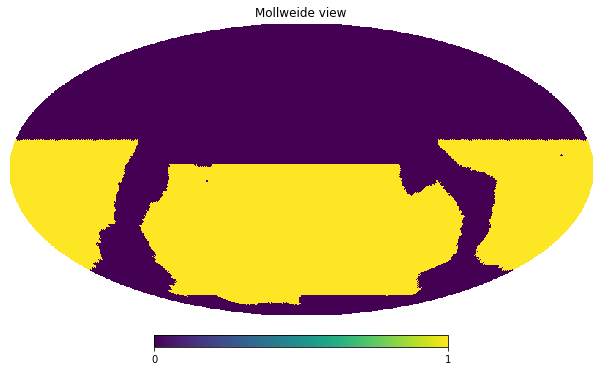

In [30]:
print('area in wfd footprint', len(np.where(wfd_footprint>0)[0]) * hp.nside2pixarea(nside, degrees=True))
hp.mollview(np.where(wfd_footprint>0, 1, 0))

In [31]:
b = {}
b['median fwhm_500'] = maf.MetricBundle(maf.MedianMetric('seeingFwhm500'), maf.UniSlicer(), None)
b['fwhm_500 histogram'] = maf.MetricBundle(maf.CountMetric('seeingFwhm500'),
                                                maf.OneDSlicer('seeingFwhm500'), None)

filtercolors = {"u": "cyan", "g": "g", "r": "orange", "i": "r", "z": "m", "y": "b", 'all': 'k'}
for f in filterlist:
    sql = f'filter == "{f}"'
    plotDict = {'color': filtercolors[f]}
    b[f'median airmass {f}'] = maf.MetricBundle(maf.MedianMetric('airmass'),
                                      maf.UniSlicer(), sql)
    b[f'airmass histogram {f}'] = maf.MetricBundle(maf.CountMetric('airmass'),
                                         maf.OneDSlicer('airmass'), sql)
    b[f'median skybrightness {f}'] = maf.MetricBundle(maf.MedianMetric('skyBrightness'), maf.UniSlicer(), sql)
    b[f'skybrightness histogram {f}'] = maf.MetricBundle(maf.CountMetric('skyBrightness'),
                                                        maf.OneDSlicer('skyBrightness'), sql)
    b[f'median seeingFwhmEff {f}'] = maf.MetricBundle(maf.MedianMetric('seeingFwhmEff'), maf.UniSlicer(), sql)
    b[f'seeingFwhmEff histogram {f}'] = maf.MetricBundle(maf.CountMetric('seeingFwhmEff'),
                                                    maf.OneDSlicer('seeingFwhmEff'), sql)
    b[f'median m5 {f}'] = maf.MetricBundle(maf.MedianMetric('fiveSigmaDepth'), maf.UniSlicer(), sql)
    b[f'm5 histogram {f}'] = maf.MetricBundle(maf.CountMetric('fiveSigmaDepth'),
                                                maf.OneDSlicer('fiveSigmaDepth'), sql)
    b[f'median visit m5 {f}'] = maf.MetricBundle(maf.MedianMetric('fiveSigmaDepth'),
                                                allsky_slicer, sql, info_label='all sky',
                                                summaryMetrics=[maf.MedianMetric()])
    b[f'wfd median visit m5 {f}'] = maf.MetricBundle(maf.MedianMetric('fiveSigmaDepth'),
                                                wfd_slicer, sql, info_label='wfd',
                                                summaryMetrics=[maf.MedianMetric()])
    b[f'coadd m5 {f}'] = maf.MetricBundle(maf.Coaddm5Metric(), allsky_slicer, sql,
                                          info_label='all sky',
                                         summaryMetrics=[maf.MedianMetric()])
    b[f'wfd coadd m5 {f}'] = maf.MetricBundle(maf.Coaddm5Metric(), wfd_slicer, sql,
                                          info_label='wfd',
                                         summaryMetrics=[maf.MedianMetric()])
    b[f'Nvisits {f}'] = maf.MetricBundle(maf.CountMetric('observationStartMJD'),
                                            allsky_slicer, sql, info_label='all sky',
                                            summaryMetrics=[maf.MedianMetric()])
    b[f'wfd Nvisits {f}'] = maf.MetricBundle(maf.CountMetric('observationStartMJD'),
                                            wfd_slicer, sql, info_label='wfd',
                                            summaryMetrics=[maf.MedianMetric()])
for f in ['all']:
    sql = None
    plotDict = {'color': filtercolors[f]}
    b[f'median airmass {f}'] = maf.MetricBundle(maf.MedianMetric('airmass'),
                                      maf.UniSlicer(), sql)
    b[f'airmass histogram {f}'] = maf.MetricBundle(maf.CountMetric('airmass'),
                                         maf.OneDSlicer('airmass'), sql)
    b[f'median skybrightness {f}'] = maf.MetricBundle(maf.MedianMetric('skyBrightness'), maf.UniSlicer(), sql)
    b[f'skybrightness histogram {f}'] = maf.MetricBundle(maf.CountMetric('skyBrightness'),
                                                        maf.OneDSlicer('skyBrightness'), sql)
    b[f'median seeingFwhmEff {f}'] = maf.MetricBundle(maf.MedianMetric('seeingFwhmEff'), maf.UniSlicer(), sql)
    b[f'seeingFwhmEff histogram {f}'] = maf.MetricBundle(maf.CountMetric('seeingFwhmEff'),
                                                    maf.OneDSlicer('seeingFwhmEff'), sql)
    b[f'Nvisits {f}'] = maf.MetricBundle(maf.CountMetric('observationStartMJD'),
                                            allsky_slicer, sql, info_label='all sky',
                                            summaryMetrics=[maf.MedianMetric()])
    b[f'wfd Nvisits {f}'] = maf.MetricBundle(maf.CountMetric('observationStartMJD'),
                                            wfd_slicer, sql, info_label='wfd sky',
                                            summaryMetrics=[maf.MedianMetric()])
for k in b:
    b[k].setRunName(runName)

In [32]:
g = maf.MetricBundleGroup(b, opsim_db_file, outDir, None, dbTable='observations')
g.runAll()

Querying table observations with no constraint for columns ['seeingFwhm500', 'rotSkyPos', 'airmass', 'seeingFwhmEff', 'fieldDec', 'skyBrightness', 'observationStartMJD', 'fieldRA'].
Found 2086980 visits
Running:  ['median fwhm_500', 'median airmass all', 'median skybrightness all', 'median seeingFwhmEff all']
Completed metric generation.
Running:  ['fwhm_500 histogram']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 1490 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['airmass histogram all']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 569 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['skybrightness histogram all']
Completed metric generation.
Running:  ['seeingFwhmEff histogram all']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 1282 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['Nvisits all']
Completed metric generation.
Running:  ['wfd Nvisits all']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "z" for columns ['rotSkyPos', 'airmass', 'fiveSigmaDepth', 'seeingFwhmEff', 'fieldDec', 'skyBrightness', 'observationStartMJD', 'fieldRA']
Found 404430 visits
Running:  ['median airmass z', 'median skybrightness z', 'median seeingFwhmEff z', 'median m5 z']
Completed metric generation.
Running:  ['airmass histogram z']
Completed metric generation.
Running:  ['skybrightness histogram z']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 312 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['seeingFwhmEff histogram z']
Completed metric generation.
Running:  ['m5 histogram z']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 572 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 250 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['median visit m5 z', 'coadd m5 z', 'Nvisits z']
Completed metric generation.
Running:  ['wfd median visit m5 z', 'wfd coadd m5 z', 'wfd Nvisits z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "r" for columns ['rotSkyPos', 'airmass', 'fiveSigmaDepth', 'seeingFwhmEff', 'fieldDec', 'skyBrightness', 'observationStartMJD', 'fieldRA']
Found 464851 visits
Running:  ['median airmass r', 'median skybrightness r', 'median seeingFwhmEff r', 'median m5 r']
Completed metric generation.
Running:  ['airmass histogram r']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 354 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 592 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['skybrightness histogram r']
Completed metric generation.
Running:  ['seeingFwhmEff histogram r']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 487 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 285 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram r']
Completed metric generation.
Running:  ['median visit m5 r', 'coadd m5 r', 'Nvisits r']
Completed metric generation.
Running:  ['wfd median visit m5 r', 'wfd coadd m5 r', 'wfd Nvisits r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "g" for columns ['rotSkyPos', 'airmass', 'fiveSigmaDepth', 'seeingFwhmEff', 'fieldDec', 'skyBrightness', 'observationStartMJD', 'fieldRA']
Found 217817 visits
Running:  ['median airmass g', 'median skybrightness g', 'median seeingFwhmEff g', 'median m5 g']
Completed metric generation.
Running:  ['airmass histogram g']
Completed metric generation.
Running:  ['skybrightness histogram g']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 270 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 654 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 444 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['seeingFwhmEff histogram g']
Completed metric generation.
Running:  ['m5 histogram g']
Completed metric generation.
Running:  ['median visit m5 g', 'coadd m5 g', 'Nvisits g']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 225 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['wfd median visit m5 g', 'wfd coadd m5 g', 'wfd Nvisits g']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "y" for columns ['rotSkyPos', 'airmass', 'fiveSigmaDepth', 'seeingFwhmEff', 'fieldDec', 'skyBrightness', 'observationStartMJD', 'fieldRA']
Found 391632 visits
Running:  ['median airmass y', 'median skybrightness y', 'median seeingFwhmEff y', 'median m5 y']
Completed metric generation.
Running:  ['airmass histogram y']
Completed metric generation.
Running:  ['skybrightness histogram y']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 304 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['seeingFwhmEff histogram y']
Completed metric generation.
Running:  ['m5 histogram y']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 847 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 256 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['median visit m5 y', 'coadd m5 y', 'Nvisits y']
Completed metric generation.
Running:  ['wfd median visit m5 y', 'wfd coadd m5 y', 'wfd Nvisits y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "u" for columns ['rotSkyPos', 'airmass', 'fiveSigmaDepth', 'seeingFwhmEff', 'fieldDec', 'skyBrightness', 'observationStartMJD', 'fieldRA']
Found 134566 visits
Running:  ['median airmass u', 'median skybrightness u', 'median seeingFwhmEff u', 'median m5 u']
Completed metric generation.
Running:  ['airmass histogram u']
Completed metric generation.
Running:  ['skybrightness histogram u']
Completed metric generation.
Running:  ['seeingFwhmEff histogram u']
Completed metric generation.
Running:  ['m5 histogram u']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 278 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 230 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 352 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['median visit m5 u', 'coadd m5 u', 'Nvisits u']
Completed metric generation.
Running:  ['wfd median visit m5 u', 'wfd coadd m5 u', 'wfd Nvisits u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "i" for columns ['rotSkyPos', 'airmass', 'fiveSigmaDepth', 'seeingFwhmEff', 'fieldDec', 'skyBrightness', 'observationStartMJD', 'fieldRA']
Found 473684 visits
Running:  ['median airmass i', 'median skybrightness i', 'median seeingFwhmEff i', 'median m5 i']
Completed metric generation.
Running:  ['airmass histogram i']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 348 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['skybrightness histogram i']
Completed metric generation.
Running:  ['seeingFwhmEff histogram i']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 531 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 223 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram i']
Completed metric generation.
Running:  ['median visit m5 i', 'coadd m5 i', 'Nvisits i']
Completed metric generation.
Running:  ['wfd median visit m5 i', 'wfd coadd m5 i', 'wfd Nvisits i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


#### Airmass #### 
The median airmass is about X=1.2, which is consistent with previous assumptions for calculating 'typical' m5 depths in work like the Overview Paper. Increasing the airmass decreases the m5 value by kAtm*(X-1), but increasing the airmass also changes the delivered seeing and skybrightness values, so has a larger effect on the resulting change in m5. Note that this will not change Cm at all, as Cm is independent of observing conditions.

In [33]:
# Visualize the range of airmasses 
ph = maf.PlotHandler(outDir='m5_metrics', thumbnail=False, figformat='pdf')
ph.setMetricBundles([b['airmass histogram']])
plotDict = {'figsize': (8, 5), 
            'title': f'{runName} Airmass histogram', 
            'yMin': 0,
            'linewidth': 2,
           'label': f"Median {b['median airmass'].metricValues[0]:.2f}",
           'legendloc': (0.8, 0.5)}
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotDict)
plt.axvline(b['median airmass'].metricValues[0], color='k')

KeyError: 'airmass histogram'

#### Seeing ####
The median atmospheric contribution to the seeing (FWHM_500) is 0.72", which is close to but not quite the same as the 'median db_seeing' evaluated above. Differences can arise due to when observations are acquired, thus skipping some of the database values (due to downtime or other telescope closures, as the database above is a continuously running model estimate used to generate fwhm_500 at the precise times of observations). 

In [ ]:
# Visualize the range of atmospheric seeing -- this should be close to the 'db_seeing' above, but may 
# slightly differ due to including or not including some of the database values (due to daytime, downtime, etc)
ph.setMetricBundles([b['fwhm_500 histogram']])
plotDict = {'figsize': (8, 5), 
            'title': f'{runName} fwhm_500 histogram', 
            'yMin': 0, 'xMin': 0,
            'linewidth': 2,
           'label': f"Median {b['median fwhm_500'].metricValues[0]:.2f} arcseconds",
           'legendloc': (0.7, 0.5),
           'fontsize': 'large'}
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotDict)
plt.axvline(b['median fwhm_500'].metricValues[0], color='k')

The delivered seeing depends on the bandpass, as well as the airmass, in which a visit is acquired. It includes the telescope and dome contributions to the atmospheric seeing.

In [ ]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'seeingFwhmEff histogram {f}'])
    key = f'median seeingFwhmEff {f}'
    plotList.append({'linewidth': 2, 
                     'legendloc': (0.7, 0.5), 
                     'figsize': (8, 5),
                     'title': f'{runName} seeingFwhmEff histogram', 
                    'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':27000, 
            'xMin': 0.4, 'xMax': 3,
           'fontsize': 'large'}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

In [ ]:
# We can compare these per-band median seeing values from the simulation
# with the expected seeing per-band from the median fwhm500 at X=1.2
# We see they are pretty close, so we're distributing visits in seeing and airmass fairly well between filters
predicted_median_x1 = seeing_model(b['median fwhm_500'].metricValues[0], 1.0)['fwhmEff']
predicted_median = seeing_model(b['median fwhm_500'].metricValues[0], 1.2)['fwhmEff']
simulated_median_seeing = []
for f in filterlist:
    simulated_median_seeing.append(b[f'median seeingFwhmEff {f}'].metricValues[0])

print('median fwhm_500', b['median fwhm_500'].metricValues[0])
d = pd.DataFrame([predicted_median_x1, predicted_median, simulated_median_seeing], 
             index=['Predicted median fwhm X=1.0', 'Predicted median fwhmEff (X=1.2)', 'Simulated median fwhmEff'],
             columns=filterlist)
d

In [ ]:
dd = dmag(d) - dmag(d.loc['Predicted median fwhm X=1.0'])
print("expected changes in m5 due to change in seeing")
dd

#### Skybrightness ####
Along with airmass and seeing, the actual range of skybrightness is also important for single visit m5 depth. 

In [ ]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'skybrightness histogram {f}'])
    key = f'median skybrightness {f}'
    plotList.append({'figsize': (8, 6), 'fontsize': 'large',
                     'linewidth': 2, 'legendloc': (0.05, 0.7),
                     'title': f'{runName} skybrightness histogram', 
                     'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':20000}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

In [ ]:
# and of course these per-band skybrightness values cover a wider range than the dark-sky values
simulated_median_skybrightness = {}
for f in filterlist:
    simulated_median_skybrightness[f] = b[f'median skybrightness {f}'].metricValues[0]

pd.DataFrame([dark_sky, simulated_median_skybrightness], 
             index=['Dark sky skybrightness', 'Simulated median skybrightness'],
             columns=filterlist)

Choosing filters appropriately for the lunar phase helps keeps these skybrightness values closer to the 'dark sky' values, but the redder filters still experience some increase in background skybrightness. The redder filters are used primarily during bright times and twilight; it is to be expected that the sky brightness is higher.

Using the same scaling relationship we use in the cadence simulation, we can evaluate the impact of each of these contributions 'separately' (even though they are not entirely independent in reality). 
Compare against 'seeing+sky X=1' -- seeing == database median fwhmEff per band, airmass = 1, sky = skybrightness model dark sky

In [ ]:
m5.keys()

In [ ]:
sim_m5 = {}
#keys = ['srd', 'fiducial throughputs', 'model sky', 'model sky + model seeing', 'cadence reference',
keys = ['model sky + model seeing', 'model dark sky + model sim seeing', 
        'sim airmass (1.2)', 'sim seeing (1")',  'sim skybrightness median', 'medians combo']
for k in keys:
    sim_m5[k] = {}
    
expTime = {}
nexp = {}
for f in filterlist:
    expTime[f] = 15
    nexp[f] = 2
expTime['u'] = 30
nexp['u'] = 1

for f in filterlist:
    sim_m5['model sky + model seeing'][f] = m5['model sky + model seeing'][f]
    sim_m5['model dark sky + model sim seeing'][f] = m5['model dark sky + sim median seeing X=1.0'][f]
    sim_m5['sim skybrightness median'][f] = rsUtils.m5_flat_sed(f, 
                                                  simulated_median_skybrightness[f],
                                                  db_fwhmEff[f],
                                                 expTime[f], airmass=1, nexp=nexp[f])
    sim_m5['sim airmass (1.2)'][f] = rsUtils.m5_flat_sed(f, 
                                           dark_sky[f],
                                           db_fwhmEff[f], 
                                           expTime[f], 
                                           airmass=b['median airmass'].metricValues[0],
                                            nexp=nexp[f])
    sim_m5['sim seeing (1")'][f] = rsUtils.m5_flat_sed(f,
                                          dark_sky[f],
                                          b[f'median seeingFwhmEff {f}'].metricValues[0],
                                          expTime[f],
                                          airmass=1.0,
                                          nexp=nexp[f])
    sim_m5['medians combo'][f] = rsUtils.m5_flat_sed(f,
                                          simulated_median_skybrightness[f],
                                          b[f'median seeingFwhmEff {f}'].metricValues[0],
                                          expTime[f],
                                          airmass=b['median airmass'].metricValues[0],
                                          nexp=nexp[f])
d = pd.DataFrame(sim_m5)
# Show decrease in magnitude limit due to each component and total
#d.subtract(d['model sky + model seeing'], axis=0)*-1
d.subtract(d['model dark sky + model sim seeing'], axis=0)*-1

We can compare these against the individual visit m5 in the simulations, to check on these 'typical' median values. 

In [ ]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'm5 histogram {f}'])
    key = f'median m5 {f}'
    plotList.append({'figsize': (8, 6), 'fontsize': 'large',
                     'linewidth': 2, 'legendloc': (0.05, 0.7),
                     'title': f'{runName} single visit m5 histogram', 
                     'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':10000}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

In [ ]:
sim_m5['simulation'] = {}
for f in filterlist:
    sim_m5['simulation'][f] = b[f"median m5 {f}"].metricValues[0]
d = pd.DataFrame(sim_m5)
d.subtract(d['model dark sky + model sim seeing'], axis=0) * -1

The "typical" values of airmass, seeing, and skybrightness result in changes in the single visit limiting magnitude which correspond well to the median individual visit depths from the simulation. We can then trace the changes in limiting magnitude according to conditions; note that Cm has been constant throughout all of the simulation evaluation.

In [ ]:
d = pd.DataFrame(m5).join(pd.DataFrame(sim_m5).drop('model sky + model seeing', axis=1))
c = pd.DataFrame(Cm)

In [ ]:
c.add_prefix('Cm ')  # Note that u band Cm values are problematic due to read-noise interference

In [ ]:
c.subtract(c['srd'], axis=0).add_prefix('Cm ')

In [ ]:
d.add_prefix('m5 ')

In [ ]:
d.subtract(d['srd min'], axis=0).add_prefix('m5 ')

In [ ]:
d.subtract(d['model sky + model seeing'], axis=0).add_prefix('m5 ')

The biggest drop is in r band -- which does fall compared to SRD design values with our current throughputs (it also shows up in the Cm values). 

All bandpasses meet SRD minimum requirements for Cm. 
All bandpasses other than r band meet SRD design requirements for Cm.

In [ ]:
Cm_min  = {}

for f in filterlist:
    Cm_min[f] = m5_to_Cm(m5_min[f], skymag_srd[f], seeing_srd[f], kAtm_srd[f], X=1.0)
(pd.DataFrame([Cm_min, Cm['srd'], Cm_cadence_reference], 
             index=['Cm minimum requirement', 'Cm SRD design', 'Cm model seeing + model sky']) - Cm_min).T

The final m5 values do fall below SRD m5 single visit expectations, but this is due to 
* evolving understanding of the atmospheric delivered seeing (FWHM_500 was 0.43" for the SRD, became 0.62" for the fiducial values, and is now 0.72" median value over 10 years for the simulation inputs). This is visible even before adding a range of observing conditions, in the `seeing X=1` values, as well. This has an impact of about 0.16 magnitudes. The final atmospheric contribution to seeing will be determined by weather.
* observing in a range of skybrightness conditions. This has an impact of between 0.3 to 0.03 magnitudes, depending on bandpass. The redder bands suffer larger losses, but also have higher throughputs compared to the SRD. This is generally unavoidable, as dark time must be used for the bluer bandpasses where sky brightness variations are larger.
* observing at a range of airmasses, with a median of X=1.2. This has an impact of between 0.1 to 0.01 magnitudes, depending on bandpass.  This is a minimal impact for the overall gain of survey flexibility, longer seasonal availability, and better parallax determination. Note that future survey choices may make larger impacts here, if observations are driven to higher airmass.
* in the r band, choices related to balancing red and blue throughput and the mirror coatings result in slightly lower throughput overall. (this should be run past Chuck for validation .. but I believe the choice of Al instead of Ag for the mirror coatings were where the r band throughput dropped to its current level). 

In [ ]:
# Per amp calculations (done in separate script, saved to output file)
from ast import literal_eval

def get_m5all(f):
    '''
    f is filter, can be u,g,r,i,z,y
    '''
    m5all = []
    m5vals = pd.read_csv('/Users/lynnej/other_repos/f_factors/source/m5_by_amp/m5_output/m5df_13040.csv', index_col=0)
    for key in m5vals:
        res = m5vals[key].apply(literal_eval)[f]
        for res1 in res:
            m5all.append(res1)
    #print('%s band, found %.0f rafts'%(f, len(m5all)/16/9))
    while -1 in m5all:
        #get rid of the dead channels, we account for them in fF.
        m5all.remove(-1)
    #print(sum([1 if ele<0 else 0 for ele in m5all]))
    return m5all

filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
fig, ax = plt.subplots(2,3,figsize=(20,5*2))

m5_amp = {}
Cm_amp = {}
for i,f in enumerate(filterlist):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    if f == 'u':
        m5_amp[f] = np.array(get_m5all('u_30'))
    else:
        m5_amp[f] = np.array(get_m5all(f))
    Cm_amp[f] = m5_to_Cm(m5_amp[f], skyMag[f], fid_fwhmEff[f], kAtm[f], X=1.0)
    #SRD Table 7.
    mm5 = np.log10(np.mean(10**(0.8*(m5_amp[f]))))/0.8
    #break
    binlow = mm5-1
    binhigh = binlow+1.5
    bins = np.linspace(binlow, binhigh,50)
    ax[irow][icol].hist(m5_amp[f], bins, fill=False, linewidth=3)
    (y1, y2) = (ax[irow][icol].get_ylim())
    ax[irow][icol].plot([m5['srd'][f], m5['srd'][f]],[y1, y2/2], linewidth=5, color='g', 
                        label=f"SRD design ({m5['srd'][f]:.1f})")
    ax[irow][icol].plot([m5['srd min'][f], m5['srd min'][f]],[y1, y2/2], linewidth=5, color='r', 
                        label=f"SRD minimum ({m5['srd min'][f]:.1f})")
    #ax[irow][icol].plot([m52019[i], m52019[i]],[y1, y2], linewidth=5, color='b', label='Summer 2019')
    ax[irow][icol].plot([mm5, mm5],[y1, y2], linewidth=5, color='y', 
                        label=f'Per amp mean ({mm5:.1f})')
    #ax[irow][icol].text(0.85, 0.48, f, color = 'black', transform=ax[irow][icol].transAxes, fontsize=15)
    #ax[irow][icol].text(0.67, 0.28, '  design = %.1f\n       min = %.1f\naverage = %.1f'%(m5design[i], m5min[i], mm5), 
    #                    color = 'black', transform=ax[irow][icol].transAxes, fontsize=13)
    ax[irow][icol].legend(fancybox=True, numpoints=1, fontsize='large')
    ax[irow][icol].set_title(f'{f} Filter', fontsize='large')

plt.tight_layout()

In [ ]:
# Same plot - but with Cm not m5
fig, ax = plt.subplots(2,3,figsize=(20,5*2))
for i,f in enumerate(filterlist):
    irow = np.int8(i/3)
    icol = np.mod(i,3)

    cm5 = np.log10(np.mean(10**(0.8*(Cm_amp[f]))))/0.8
    #break
    binlow = cm5-1
    binhigh = binlow+1.5
    bins = np.linspace(binlow, binhigh,50)
    ax[irow][icol].hist(Cm_amp[f], bins, fill=False, linewidth=3)
    (y1, y2) = (ax[irow][icol].get_ylim())
    ax[irow][icol].plot([Cm['srd'][f], Cm['srd'][f]],[y1, y2/2], linewidth=5, color='g', 
                        label=f'SRD design ({Cm["srd"][f]:.1f})')
    ax[irow][icol].plot([Cm['srd min'][f], Cm['srd min'][f]],[y1, y2/2], linewidth=5, color='r', 
                        label=f'SRD minimum ({Cm["srd min"][f]:.1f})')
    #ax[irow][icol].plot([m52019[i], m52019[i]],[y1, y2], linewidth=5, color='b', label='Summer 2019')
    ax[irow][icol].plot([cm5, cm5],[y1, y2], linewidth=5, color='y', 
                        label=f'Per amp mean ({mm5:.1f})')
    #ax[irow][icol].text(0.85, 0.48, f, color = 'black', transform=ax[irow][icol].transAxes, fontsize=15)
    #ax[irow][icol].text(0.67, 0.28, '  design = %.1f\n       min = %.1f\naverage = %.1f'%(m5design[i], m5min[i], mm5), 
    #                    color = 'black', transform=ax[irow][icol].transAxes, fontsize=13)
    ax[irow][icol].legend(fancybox=True, numpoints=1, fontsize='large')
    ax[irow][icol].set_title(f'{f} Filter', fontsize='large')

plt.tight_layout()

In [ ]:
# What is the effective readnoise, that recreates the mean Cm values and the mean m5 values from above?
# Have to consider that above values include vignetting, which in general we don't include
# as part of SRD comparison (?) nor MAF calculations (currently)

mm5 = np.log10(np.mean(10**(0.8*(m5_amp[f]))))/0.8
cm5

#### Coadded depth ####

The single visit depth is the basis for the coadded m5 limits, however it also folds in the number of visits per pointing. 

In [ ]:
for f in filterlist:
    ph.setMetricBundles([b[f'Nvisits {f}']])
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'figsize': (8,6), 'percentileClip': 95})
    ph.setMetricBundles([b[f'coadd m5 {f}']])
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'figsize': (8,6), 'percentileClip': 95})

In [ ]:
for f in filterlist:
    ph.setMetricBundles([b[f'Nvisits {f}']])
    ph.plot(plotFunc=maf.HealpixHistogram(), plotDicts={'figsize': (8,6), 'percentileClip': 99, 'bins':50})
    ph.setMetricBundles([b[f'coadd m5 {f}']])
    ph.plot(plotFunc=maf.HealpixHistogram(), plotDicts={'figsize': (8,6), 'percentileClip': 99, 'bins': 150})

In [ ]:
# In general, the medians for each of these metrics simply represents the WFD area, 
# as this is the overwhelming portion of the survey. 
nvisits = pd.DataFrame([b[f'Nvisits {f}'].summaryValues['Median'] for f in filterlist], 
                       index=filterlist, columns=['Nvisits'])
coadd = pd.DataFrame([b[f'coadd m5 {f}'].summaryValues['Median'] for f in filterlist], 
                     index=filterlist, columns=['Coadd m5'])
nvisits.join(coadd)

In [ ]:
nvisits.sum()

In [ ]:
nvisits_all = np.zeros(len(b['Nvisits r'].metricValues), float)
for f in filterlist:
    nvisits_all += b[f'Nvisits {f}'].metricValues.filled(0)

In [ ]:
# For WFD-only specific numbers:


Calculate the fraction of time spent on "WFD" by defining WFD as the area with >750 visits per pointing, then identifying visits which overlap these healpixels by more than 40% as 'WFD visits' (if the visits overlaps by less than 0.4 then they will not be counted towards WFD visits). 

In [ ]:
cols = ['observationStartMJD', 'fieldRA', 'fieldDec', 'rotSkyPos', 'note', 'visitExposureTime']
simdata = maf.getSimData(opsim_db_file, '', cols)

In [ ]:
wfd_footprint = np.where(nvisits_all<750, 0, 1)
stacker = maf.WFDlabelStacker(wfd_footprint, fp_threshold=0.4)
simdata = stacker.run(simdata)

In [ ]:
totalNvisits = len(simdata)
totalWFDvisits = len(simdata[np.where(simdata['proposalId'] == 1)])
fraction_wfd = totalWFDvisits/totalNvisits
print(f'Out of {totalNvisits} total visits, {totalWFDvisits} contributed to WFD coverage.')
print(f'A fraction of {fraction_wfd*100:.1f}%.')

In [ ]:
fOsummaries = [maf.fONv(Asky=18000.0, nside=64, Nvisit=750, norm=True),
               maf.fOArea(Asky=18000.0, nside=64, Nvisit=750, norm=True)]
metric = maf.CountExplimMetric(col='observationStartMJD', metricName="fO", expCol='visitExposureTime')
slicer = maf.HealpixSlicer(nside=64)
fObundle = maf.MetricBundle(metric, slicer, '', runName=runName, summaryMetrics=fOsummaries)

In [ ]:
g = maf.MetricBundleGroup({'fO': fObundle}, opsim_db_file, 'm5_metrics', None)
g.runCurrent('', simData=simdata)

In [ ]:
median_nvis_18k = fObundle.summaryValues['fONv'][0][-1]
minimum_nvis_18k = fObundle.summaryValues['fONv'][1][-1]
area_with_750visits = fObundle.summaryValues['fOArea']
print(f'The median number of visits per pointing, in the top 18,0000 sq degrees is {median_nvis_18k*750}.')
print(f'The minimum number of visits per pointing, in the top 18,0000 sq degrees is {minimum_nvis_18k*750}.')
print(f'The area on sky with at least 750 visits per pointing is {area_with_750visits*18000} sq degrees.')

As the SRD is worded, the requirement is to cover at least 18,000 sq degrees with a median of at least 750 (minimum) or 825 (design) visits per pointing. This comes closest to the `median_nvis_18k` above, and over this 18,000 sq degrees we reach a median number of visits per pointing > 825.

In [ ]:
print('Potentially, we could direct all non-WFD visits into WFD area as "reserve".')
print(f'This implies we have a "reserve" of {median_nvis_18k / fraction_wfd} on the ' \
      'median number of visits per pointing over 18k sq degrees above.')

In [ ]:
print('Potentially, we could direct all non-WFD visits into WFD area as "reserve".')
print(f'This implies we have a "reserve" of {minimum_nvis_18k / fraction_wfd} on the ' \
      'minimum number of visits per pointing over 18k sq degrees above.')

In [ ]:
# Growth of coadded depth with number of visits - separate per band so they have their own scale\
# Assume each visit is the median single visit depth

expTime = {}
nexp = {}
for f in filterlist:
    expTime[f] = 15
    nexp[f] = 2
expTime['u'] = 30
nexp['u'] = 1
nvisits_max = {'u': 80, 'g': 100, 'r': 180, 'i': 180, 'z': 200, 'y': 200}
plt.figure(figsize=(13, 10))
j=1
for f in ('u', 'g', 'r', 'i', 'z', 'y'):
    plt.subplot(2,3,j)
    nvisitrange = np.arange(0, nvisits_max[f], 1)
    m5_t = np.zeros(len(nvisitrange), float)
    for i, nvis in enumerate(nvisitrange):
        m5_t[i] = rsUtils.m5_flat_sed(f, simulated_median_skybrightness[f],
                              b[f'median seeingFwhmEff {f}'].metricValues[0],
                              expTime[f],
                              airmass=b['median airmass'].metricValues[0],
                              nexp=nvis*nexp[f])
    # last 10% of total visits gains what depth?
    i = nvisits_max[f]-10
    last10percent = int(0.9*i)
    dm5_final = m5_t[i] - m5_t[last10percent]
    label = f'{f} band deltaM5 in final 10% ({i - last10percent} visits): {dm5_final:.2f} mag'
    print(label)
    # alternatively, the last 20 visits gains what depth?
    i = nvisits_max[f] - 1
    last20 = i - 20
    dm5_final = m5_t[i] - m5_t[last20]
    label = f'{f} band deltaM5 in final 20 visits ({(i-last20)/i}%): {dm5_final:.2f} mag'
    print(label)
    plt.plot(nvisitrange, m5_t, color=filtercolors[f], linestyle='-')           
    plt.grid(True)
    plt.xlabel(r'Number of visits', fontsize='x-large')
    plt.ylabel(r'Coadded m5', fontsize='x-large')
    j+=1
plt.suptitle(f'Limiting magnitude for a series of median depth LSST observations', fontsize='x-large')
plt.tight_layout()

In [ ]:
# Compare the expected coadded depths from combining median visits to the achieved coadded visits
# Looking for impact from tails of distributions, doesn't seem terrible, although i band is approaching 10%
predicted_coadd = {}
for f in filterlist:
      predicted_coadd[f] = rsUtils.m5_flat_sed(f, simulated_median_skybrightness[f],
                              b[f'median seeingFwhmEff {f}'].metricValues[0],
                              expTime[f],
                              airmass=b['median airmass'].metricValues[0],
                              nexp=nvisits.loc[f][0]*nexp[f])
d = nvisits.join(coadd).join(pd.DataFrame([predicted_coadd], index=['Predicted coadd m5']).T)
d

In [ ]:
d['Coadd m5'] - d['Predicted coadd m5']

In [ ]:
# what if we increased the r band exposure time?
f = 'r'

# Assume the dark sky sed is good to use for the shape of the sky, but rescale to have the expected
# dark_sky value magnitude
darksky_copy = photUtils.Sed()
darksky_copy.setSED(wavelen = darksky.wavelen, flambda = darksky.flambda)
fluxNorm = darksky_copy.calcFluxNorm(dark_sky[f], hardware[f])
darksky_copy.multiplyFluxNorm(fluxNorm)
m5_r_30 = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                         photParams[f], FWHMeff=db_fwhmEff[f])
photParameters_40 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1, 
                                                     readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
m5_r_40 = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                         photParameters_40, FWHMeff=db_fwhmEff[f])
print(m5['model sky + model seeing']['r'], m5_r_30, m5_r_40)

In [ ]:
new_readnoise = 6.3
print(new_readnoise, readnoise)
photParameters_new_15 = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1, 
                                                     readnoise=new_readnoise, othernoise=0, darkcurrent=darkcurrent)
photParameters_new_30 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1, 
                                                     readnoise=new_readnoise, othernoise=0, darkcurrent=darkcurrent)

photParams_new = {}
photParams_new['u'] = photParameters_new_30
for f in ('g', 'r', 'i', 'z', 'y'):
    photParams_new[f] = photParameters_new_15
    
k = 'm5 per amp calculation'  # readout time 2.323s 
m5[k] = {}
Cm[k] = {}
m5[k]['u'] = 23.791655
m5[k]['g'] = 24.739844
m5[k]['r'] = 24.343305
m5[k]['i'] = 23.916932
m5[k]['z'] = 23.340589
m5[k]['y'] = 22.313510
for f in filterlist:
    Cm[k][f] = m5_to_Cm(m5[k][f], skyMag[f], fid_fwhmEff[f], kAtm[f], X=1.0)
    
k = 'fiducial + new rd'
m5[k] = {}
Cm[k] = {}
for f in filterlist:
    m5[k][f] = photUtils.calcM5(darksky, system[f], hardware[f],
                                             photParams_new[f], FWHMeff=fid_fwhmEff[f])
    Cm[k][f] = m5_to_Cm(m5[k][f], skyMag[f], fid_fwhmEff[f], kAtm[f], X=1.0)

k = 'model sky + model seeing + new rd'
m5[k] = {}
Cm[k] = {}
for f in filterlist:
    darksky_copy = photUtils.Sed()
    darksky_copy.setSED(wavelen = darksky.wavelen, flambda = darksky.flambda)
    fluxNorm = darksky_copy.calcFluxNorm(dark_sky[f], hardware[f])
    darksky_copy.multiplyFluxNorm(fluxNorm)
    m5[k][f] = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                             photParams_new[f], FWHMeff=db_fwhmEff[f])
    Cm[k][f] = m5_to_Cm(m5[k][f], dark_sky[f], db_fwhmEff[f], kAtm[f], X=1.0)

    
keys = ['srd', 'srd throughputs', 'fiducial throughputs', 'model sky', 'model sky + model seeing', 
       'm5 per amp calculation', 'fiducial + new rd', 'model sky + model seeing + new rd']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])
d = pd.DataFrame([m5[k] for k in keys],
            index=[f'm5 {k}' for k in keys])
d #- d.loc['m5 m5 per amp calculation']


